In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from tensorflow import keras

In [2]:

from time import sleep
from winsound import Beep
from pathlib import Path
import yaml

In [3]:
def write_yaml(file_path: str, data: object):
    """
    Write data to a YAML file.

    Args:
        file_path (str): Path of the YAML file.
        data (object): Data to write.

    Returns:
        bool: True if the file was written successfully, False otherwise.
    """
    try:
        with open(Path(file_path), "w") as f:
            yaml.dump(data, f)
        print("YAML file write: OK")
        return True
    except (FileNotFoundError, IOError, yaml.YAMLError) as err:
        print(f"Failed to write YAML file {file_path}: {err}")
        return False

In [4]:
def bee(r: int = 3, f: int = 2500, d: int = 1000, p: float = 1) -> None:
    """
    Emits a series of sounds using the Beep function from the winsound library.

    Args:
        r (int): Number of sound repetitions (default: 3).
        f (int): Sound frequency in Hz (default: 2500).
        d (int): Sound duration in milliseconds (default: 1000).
        p (float): Pause between each sound in seconds (default: 1).

    Returns:
        None
    """
    
    for n in range(r):
        Beep(f, d)
        sleep(p)

## Declaramos variables y cargamos los datos

In [5]:
parameter = {}
score = {}

In [6]:
medium_df = pd.read_csv("../data/processed/medium.csv", index_col="Unnamed: 0")

In [7]:
medium_df.columns

Index(['demography_score', 'type_score', 'score', 'read', 'book_status_score',
       'pending', 'following', 'favorite', 'have', 'abandoned',
       'chapters_count', 'tdg'],
      dtype='object')

# Preproceso

In [8]:
X = medium_df.drop("score", axis=1)
y = medium_df["score"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Scaler

In [10]:
# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X_train) # Lo "entreno". Calculo su media y std para cada feature
X_train_scal = scal.transform(X_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X_test_scal = scal.transform(X_test)


### PCA


In [11]:
# Aplicar PCA para reducir la dimensionalidad de los datos
pca = PCA(n_components=len(medium_df.columns)-1)
# Ajustar y transformar los datos de entrenamiento utilizando PCA
X_train_pca = pca.fit_transform(X_train)
# Transformar los datos de prueba utilizando el modelo PCA ajustado previamente
X_test_pca = pca.transform(X_test)

In [12]:
# Obtener la proporción de varianza explicada por cada componente principal
pca.explained_variance_ratio_

array([8.93174854e-01, 8.22723676e-02, 1.50791279e-02, 8.44039646e-03,
       8.62360778e-04, 1.37311168e-04, 3.35725990e-05, 5.01738009e-09,
       2.74534310e-09, 1.44456154e-09, 5.73402624e-10])

In [13]:
# Obtener la varianza explicada acumulada por cada componente principal
pca.explained_variance_ratio_.cumsum()

array([0.89317485, 0.97544722, 0.99052635, 0.99896675, 0.99982911,
       0.99996642, 0.99999999, 1.        , 1.        , 1.        ,
       1.        ])

# Polynomial + LinearRegression + PCA

- `poly_feats = PolynomialFeatures(degree=2)`: Se crea un objeto `PolynomialFeatures` con grado 2, lo que indica que se generarán características polinómicas hasta el segundo grado.

- `poly_feats.fit(X)`: Se ajusta el objeto `PolynomialFeatures` a los datos de entrada `X`. Esto calcula los coeficientes necesarios para generar las características polinómicas.

- `X_poly = poly_feats.transform(X)`: Se transforman los datos de entrada `X` utilizando el objeto `PolynomialFeatures` ajustado previamente. Esto agrega las características polinómicas al conjunto de datos original, generando así una representación de mayor dimensionalidad.

- `lin_reg = LinearRegression()`: Se crea un objeto `LinearRegression` para realizar una regresión lineal.

- `lin_reg.fit(X_train_pca, y_train)`: Se ajusta el modelo de regresión lineal utilizando los datos de entrenamiento con componentes principales `X_train_pca` y las etiquetas correspondientes `y_train`. Esto encuentra los coeficientes óptimos para la línea de regresión.


In [14]:
# Crear un objeto PolynomialFeatures para generar características polinómicas de grado 2
poly_feats = PolynomialFeatures(degree=2)

# Ajustar PolynomialFeatures a los datos de entrada X
poly_feats.fit(X)

# Transformar los datos de entrada X para incluir características polinómicas
X_poly = poly_feats.transform(X)

# Crear un objeto LinearRegression para realizar una regresión lineal
lin_reg = LinearRegression()

# Ajustar el modelo de regresión lineal utilizando los datos de entrenamiento con componentes principales
lin_reg.fit(X_train_pca, y_train)


LinearRegression()

In [15]:
parameter["plr"] = {"poli__degree": [2]}

In [16]:
predictions = lin_reg.predict(X_test_pca)

In [17]:
MAE = mean_absolute_error(y_test, predictions)
MAPE = mean_absolute_percentage_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
R2_Train = lin_reg.score(X_train_pca, y_train)
R2_Test = lin_reg.score(X_test_pca, y_test)

In [18]:
score["plr"] = {"MAE": float(MAE), "MAPE": float(MAPE), "MSE": float(MSE), 
                "RMSE": float(RMSE), "R2_Train": float(R2_Train), "R2_Test": float(R2_Test)}

In [19]:
print("MAE:", MAE)
print("MAPE:", MAPE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R2_Train:", R2_Train)
print("R2_Test:", R2_Test)

MAE: 1.8729023947316694
MAPE: 3642305621068901.0
MSE: 5.493464488636974
RMSE: 2.3438140900329474
R2_Train: 0.631883002912361
R2_Test: 0.6372847166908994


# RandomForestRegressor

- `model = RandomForestRegressor(random_state=10)`: Se crea un objeto `RandomForestRegressor` con un estado aleatorio de 10. Este modelo se utiliza para realizar una regresión utilizando un conjunto de árboles de decisión.

- `parameters = {...}`: Se definen los parámetros para la búsqueda de hiperparámetros. En este caso, se especifican diferentes valores para los hiperparámetros como el número de estimadores (`n_estimators`), la profundidad máxima del árbol (`max_depth`), el número mínimo de muestras en las hojas del árbol (`min_samples_leaf`) y el número máximo de características a considerar en cada división (`max_features`).

- `dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)`: Se crea un objeto `GridSearchCV` para realizar una búsqueda exhaustiva de los mejores hiperparámetros para el modelo de regresión utilizando validación cruzada. Se especifica el modelo (`model`), los parámetros a buscar (`parameters`), el número de divisiones de la validación cruzada (`cv=5`), la métrica de evaluación (`scoring="neg_mean_absolute_error"`) y el número de trabajos en paralelo (`n_jobs=-1`) para acelerar el proceso de búsqueda.


In [20]:
# Crear un objeto RandomForestRegressor con un estado aleatorio de 10
model = RandomForestRegressor(random_state=10)

# Definir los parámetros para la búsqueda de hiperparámetros
parameters = {
    "n_estimators": [150, 200],
    "max_depth": [13],
    "min_samples_leaf": [2, 3, 4],
    "max_features": [6]
}

# Crear un objeto GridSearchCV para realizar una búsqueda exhaustiva de hiperparámetros
dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)


In [21]:
dtr_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=10), n_jobs=-1,
             param_grid={'max_depth': [13], 'max_features': [6],
                         'min_samples_leaf': [2, 3, 4],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_absolute_error')

In [22]:
best_params = {}
[best_params.update({f"regressor__{key}": [value]}) for key, value in dtr_gs.best_params_.items()]
parameter["rfr"] = best_params

In [23]:
feature_importances = dtr_gs.best_estimator_.feature_importances_
feature_importances_dict = dict(zip(X.columns, feature_importances))
feature_importances_sort = sorted(feature_importances_dict.items(), key=lambda x:x[1], reverse=True)

In [24]:
feature_importances_sort

[('tdg', 0.61797282501912),
 ('pending', 0.061907672190249265),
 ('read', 0.06127357263574533),
 ('type_score', 0.04373127405952414),
 ('favorite', 0.04238599304748581),
 ('book_status_score', 0.04057401258628702),
 ('following', 0.039546644901186215),
 ('chapters_count', 0.02927698361497557),
 ('have', 0.02818377628837465),
 ('abandoned', 0.017976562824306895),
 ('demography_score', 0.01717068283274519)]

In [25]:
predictions = dtr_gs.predict(X_test)

In [26]:
MAE = mean_absolute_error(y_test, predictions)
MAPE = mean_absolute_percentage_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
R2_Train = dtr_gs.best_estimator_.score(X_train, y_train)
R2_Test = dtr_gs.best_estimator_.score(X_test, y_test)

In [27]:
score["rfr"] = {"MAE": float(MAE), "MAPE": float(MAPE), "MSE": float(MSE), "RMSE": float(RMSE),
                "R2_Train": float(R2_Train), "R2_Test": float(R2_Test)}

In [28]:
print("MAE:", MAE)
print("MAPE:", MAPE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R2_Train:", R2_Train)
print("R2_Test:", R2_Test)

MAE: 0.8898398043706012
MAPE: 1568007958161719.8
MSE: 2.3319061895209843
RMSE: 1.5270580177324582
R2_Train: 0.9384981051525723
R2_Test: 0.8460319501597049


# ElasticNet

- `model = ElasticNet()`: Se crea un objeto `ElasticNet`. Este modelo combina la regularización L1 y L2 para realizar una regresión lineal con términos de penalización tanto en los coeficientes como en su magnitud.

- `parameters = {...}`: Se definen los parámetros para la búsqueda de hiperparámetros. En este caso, se especifican diferentes valores para los hiperparámetros `alpha`, que controla la fuerza de la regularización, `l1_ratio`, que determina la mezcla entre la regularización L1 y L2, y `max_iter`, que indica el número máximo de iteraciones del algoritmo de optimización.

- `dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)`: Se crea un objeto `GridSearchCV` para realizar una búsqueda exhaustiva de los mejores hiperparámetros para el modelo ElasticNet utilizando validación cruzada. Se especifica el modelo (`model`), los parámetros a buscar (`parameters`), el número de divisiones de la validación cruzada (`cv=5`), la métrica de evaluación (`scoring="neg_mean_absolute_error"`) y el número de trabajos en paralelo (`n_jobs=-1`) para acelerar el proceso de búsqueda.


In [29]:
# Crear un objeto ElasticNet
model = ElasticNet()

# Definir los parámetros para la búsqueda de hiperparámetros
parameters = {
    "alpha": [0.1, 0.5, 1.0],
    "l1_ratio": [0.3, 0.5, 0.7, 0.9],
    "max_iter": [1000, 2000]
}

# Crear un objeto GridSearchCV para realizar una búsqueda exhaustiva de hiperparámetros
dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)


In [30]:
dtr_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0],
                         'l1_ratio': [0.3, 0.5, 0.7, 0.9],
                         'max_iter': [1000, 2000]},
             scoring='neg_mean_absolute_error')

In [31]:
best_params = {}
[best_params.update({f"regressor__{key}": [value]}) for key, value in dtr_gs.best_params_.items()]
parameter["en"] = best_params

In [32]:
predictions = dtr_gs.predict(X_test)

In [33]:
MAE = mean_absolute_error(y_test, predictions)
MAPE = mean_absolute_percentage_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
R2_Train = dtr_gs.best_estimator_.score(X_train, y_train)
R2_Test = dtr_gs.best_estimator_.score(X_test, y_test)

In [34]:
score["en"] = {"MAE": float(MAE), "MAPE": float(MAPE), "MSE": float(MSE), "RMSE": float(RMSE), 
                "R2_Train": float(R2_Train), "R2_Test": float(R2_Test)}

In [35]:
print("MAE:", MAE)
print("MAPE:", MAPE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R2_Train:", R2_Train)
print("R2_Test:", R2_Test)

MAE: 2.0280036929033907
MAPE: 4307619621270913.0
MSE: 6.267992454767642
RMSE: 2.5035959048471943
R2_Train: 0.5842224169349084
R2_Test: 0.5861451978595669


# Support Vector Regression (SVR)

- `model = SVR()`: Se crea un objeto SVR (Support Vector Regression). Este modelo se utiliza para realizar una regresión utilizando la técnica de Support Vector Machines (SVM).

- `parameters = {...}`: Se definen los parámetros para la búsqueda de hiperparámetros. En este caso, se especifican diferentes valores para los hiperparámetros `kernel`, que determina el tipo de kernel a utilizar (`rbf` o `poly`), `C`, que controla la penalización por error de entrenamiento y la complejidad del modelo, y `epsilon`, que establece el margen de error permitido en la regresión.

- `dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)`: Se crea un objeto `GridSearchCV` para realizar una búsqueda exhaustiva de los mejores hiperparámetros para el modelo SVR utilizando validación cruzada. Se especifica el modelo (`model`), los parámetros a buscar (`parameters`), el número de divisiones de la validación cruzada (`cv=5`), la métrica de evaluación (`scoring="neg_mean_absolute_error"`) y el número de trabajos en paralelo (`n_jobs=-1`) para acelerar el proceso de búsqueda.


In [36]:
# Crear un objeto SVR
model = SVR()

# Definir los parámetros para la búsqueda de hiperparámetros
parameters = {
    "kernel": ["rbf", "poly"],
    "C": [0.5, 1, 2],
    "epsilon": [0.01, 0.1, 0.3],
}

# Crear un objeto GridSearchCV para realizar una búsqueda exhaustiva de hiperparámetros
dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)


In [37]:
dtr_gs.fit(X_train_scal, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.5, 1, 2], 'epsilon': [0.01, 0.1, 0.3],
                         'kernel': ['rbf', 'poly']},
             scoring='neg_mean_absolute_error')

In [38]:
best_params = {}
[best_params.update({f"regressor__{key}": [value]}) for key, value in dtr_gs.best_params_.items()]
parameter["svr"] = best_params

In [39]:
dtr_gs.best_params_

{'C': 2, 'epsilon': 0.01, 'kernel': 'rbf'}

In [40]:
predictions = dtr_gs.predict(X_test_scal)

In [41]:
MAE = mean_absolute_error(y_test, predictions)
MAPE = mean_absolute_percentage_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
R2_Train = dtr_gs.best_estimator_.score(X_train_scal, y_train)
R2_Test = dtr_gs.best_estimator_.score(X_test_scal, y_test)

In [42]:
score["svr"] = {"MAE": float(MAE), "MAPE": float(MAPE), "MSE": float(MSE), "RMSE": float(RMSE),
                "R2_Train": float(R2_Train), "R2_Test": float(R2_Test)}

In [43]:
print("MAE:", MAE)
print("MAPE:", MAPE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R2_Train:", R2_Train)
print("R2_Test:", R2_Test)

MAE: 1.1460713680665038
MAPE: 2389076939175422.5
MSE: 3.5950331526586923
RMSE: 1.8960572651316976
R2_Train: 0.7635003210842612
R2_Test: 0.7626318562412796


# AdaBoostRegressor

- `model = AdaBoostRegressor(random_state=10)`: Se crea un objeto AdaBoostRegressor con un estado aleatorio de 10. Este modelo se utiliza para realizar una regresión utilizando el algoritmo de Boosting con la técnica de AdaBoost.

- `parameters = {...}`: Se definen los parámetros para la búsqueda de hiperparámetros. En este caso, se especifican diferentes valores para los hiperparámetros `n_estimators`, que indica el número de estimadores en el ensamblaje, y `loss`, que determina la función de pérdida a utilizar durante el entrenamiento.

- `dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)`: Se crea un objeto GridSearchCV para realizar una búsqueda exhaustiva de los mejores hiperparámetros para el modelo AdaBoostRegressor utilizando validación cruzada. Se especifica el modelo (`model`), los parámetros a buscar (`parameters`), el número de divisiones de la validación cruzada (`cv=5`), la métrica de evaluación (`scoring="neg_mean_absolute_error"`) y el número de trabajos en paralelo (`n_jobs=-1`) para acelerar el proceso de búsqueda.


In [44]:
# Crear un objeto AdaBoostRegressor
model = AdaBoostRegressor(random_state=10)

# Definir los parámetros para la búsqueda de hiperparámetros
parameters = {
    "n_estimators": [100, 150, 200],
    "loss": ["linear", "square", "exponential"],
}

# Crear un objeto GridSearchCV para realizar una búsqueda exhaustiva de hiperparámetros
dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)


In [45]:
dtr_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=10), n_jobs=-1,
             param_grid={'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [46]:
best_params = {}
[best_params.update({f"regressor__{key}": [value]}) for key, value in dtr_gs.best_params_.items()]
parameter["ada"] = best_params

In [47]:
dtr_gs.best_params_

{'loss': 'linear', 'n_estimators': 100}

In [48]:
predictions = dtr_gs.predict(X_test)

In [49]:
MAE = mean_absolute_error(y_test, predictions)
MAPE = mean_absolute_percentage_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
R2_Train = dtr_gs.best_estimator_.score(X_train, y_train)
R2_Test = dtr_gs.best_estimator_.score(X_test, y_test)

In [50]:
score["abr"] = {"MAE": float(MAE), "MAPE": float(MAPE), "MSE": float(MSE), "RMSE": float(RMSE),
                "R2_Train": float(R2_Train), "R2_Test": float(R2_Test)}

In [51]:
print("MAE:", MAE)
print("MAPE:", MAPE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R2_Train:", R2_Train)
print("R2_Test:", R2_Test)

MAE: 1.997281085166895
MAPE: 4100736842203801.5
MSE: 6.312366800968291
RMSE: 2.512442397542338
R2_Train: 0.5802620758605064
R2_Test: 0.5832153066065849


# GradientBoostingRegressor

Importamos la clase `GradientBoostingRegressor` del módulo `ensemble` de la biblioteca sklearn. Esto nos permite utilizar el algoritmo de Boosting con gradientes para realizar una regresión.

- `max_depth`: La profundidad máxima de los árboles de regresión utilizados en el ensamble. En este caso, se establece en 2.
- `n_estimators`: El número de árboles en el ensamble. En este caso, se establece en 3.
- `learning_rate`: La tasa de aprendizaje que controla la contribución de cada árbol en el ensamble. En este caso, se establece en 1.0, lo que significa que cada árbol contribuye completamente al ensamble.
- `random_state`: El estado aleatorio para reproducibilidad. En este caso, se establece en 10.


In [52]:
from sklearn.ensemble import GradientBoostingRegressor

# Crear un objeto GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=10)

# Ajustar el modelo GradientBoostingRegressor a los datos de entrenamiento
gbrt.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=10)

In [53]:
predictions = gbrt.predict(X_test)

In [54]:
MAE = mean_absolute_error(y_test, predictions)
MAPE = mean_absolute_percentage_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
R2_Train = dtr_gs.best_estimator_.score(X_train, y_train)
R2_Test = dtr_gs.best_estimator_.score(X_test, y_test)

In [55]:
score["gbr"] = {"MAE": float(MAE), "MAPE": float(MAPE), "MSE": float(MSE), "RMSE": float(RMSE),
                "R2_Train": float(R2_Train), "R2_Test": float(R2_Test)}

In [56]:
print("MAE:", MAE)
print("MAPE:", MAPE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R2_Train:", R2_Train)
print("R2_Test:", R2_Test)

MAE: 1.4013988256275487
MAPE: 2564847712389545.0
MSE: 4.512943873887506
RMSE: 2.1243690531278943
R2_Train: 0.5802620758605064
R2_Test: 0.5832153066065849


# Recurrent Neural Networks

**Model Creation:**

- `model`: Se crea un modelo secuencial de Keras utilizando la clase `Sequential`. Este modelo consiste en una serie de capas apiladas una encima de la otra.
- `keras.layers.Dense`: Se añaden capas densas (totalmente conectadas) al modelo. Cada capa tiene un número específico de neuronas y una función de activación. La última capa tiene 1 neurona para la regresión.

**Model Compilation:**

- `model.compile`: Se compila el modelo especificando la función de pérdida, el optimizador y las métricas que se utilizarán durante el entrenamiento.

**Callbacks:**

- `checkpoint_cb`: Se crea un callback `ModelCheckpoint` para guardar el modelo en un archivo durante el entrenamiento.
- `early_stopping_cb`: Se crea un callback `EarlyStopping` que detendrá el entrenamiento si no se observa una mejora en la métrica de pérdida en un número determinado de épocas.

**Model Training:**

- `model.fit`: Se entrena el modelo utilizando los datos de entrenamiento `X_train_scal` y las etiquetas correspondientes `y_train`. Se especifica el número de épocas, la validación cruzada (usando una fracción del conjunto de entrenamiento como validación) y los callbacks a utilizar durante el entrenamiento.


In [57]:
model = keras.Sequential([
    keras.layers.Dense(120, activation='relu', input_shape=X_train_scal.shape[1:]),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])

model.compile(loss='mae', optimizer=keras.optimizers.Adam(), 
                metrics=[keras.metrics.MeanAbsolutePercentageError(name="MAPE"),
                        keras.metrics.MeanSquaredError(name='MSE'),
                        keras.metrics.RootMeanSquaredError(name="RMSE")
                        ])

checkpoint_cb = keras.callbacks.ModelCheckpoint("../models/medium/callback_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train_scal, y_train, epochs=1000, validation_split=0.2,
                   callbacks = [early_stopping_cb, checkpoint_cb])

Epoch 1/1000


381/381 [==============================] - 1s 2ms/step - loss: 2.1848 - MAPE: 241496928.0000 - MSE: 12.8034 - RMSE: 3.5782 - val_loss: 1.0256 - val_MAPE: 184764160.0000 - val_MSE: 3.7833 - val_RMSE: 1.9451
Epoch 2/1000
381/381 [==============================] - 1s 1ms/step - loss: 0.9693 - MAPE: 200186128.0000 - MSE: 3.7287 - RMSE: 1.9310 - val_loss: 0.8733 - val_MAPE: 189864096.0000 - val_MSE: 3.2941 - val_RMSE: 1.8150
Epoch 3/1000
381/381 [==============================] - 1s 1ms/step - loss: 0.9014 - MAPE: 191352160.0000 - MSE: 3.5731 - RMSE: 1.8903 - val_loss: 0.8410 - val_MAPE: 174444512.0000 - val_MSE: 3.2504 - val_RMSE: 1.8029
Epoch 4/1000
381/381 [==============================] - 1s 1ms/step - loss: 0.8667 - MAPE: 172796288.0000 - MSE: 3.5253 - RMSE: 1.8776 - val_loss: 0.8550 - val_MAPE: 201443616.0000 - val_MSE: 3.3462 - val_RMSE: 1.8292
Epoch 5/1000
381/381 [==============================] - 1s 2ms/step - loss: 0.8471 - MAPE: 188387536.0000 - MSE: 3.4636 - RMSE: 1.8611 - val

In [58]:
rnn_score = model.evaluate(X_test_scal, y_test)


  1/119 [..............................] - ETA: 2s - loss: 0.4752 - MAPE: 6.0224 - MSE: 1.2774 - RMSE: 1.1302

119/119 [==============================] - 0s 1ms/step - loss: 0.7154 - MAPE: 115584688.0000 - MSE: 3.0468 - RMSE: 1.7455


In [59]:
MAE = rnn_score[0]
MAPE = rnn_score[1]
MSE = rnn_score[2]
RMSE = rnn_score[3]

In [60]:
score["rnn"] = {"MAE": float(MAE), "MAPE": float(MAPE), "MSE": float(MSE), "RMSE": float(RMSE)}

In [61]:
print("MAE:", MAE)
print("MAPE:", MAPE)
print("MSE:", MSE)
print("RMSE:", RMSE)

MAE: 0.7154382467269897
MAPE: 115584688.0
MSE: 3.0468201637268066
RMSE: 1.7455142736434937


In [62]:
y_pred = model.predict(X_test_scal).flatten()

119/119 [==============================] - 0s 839us/step


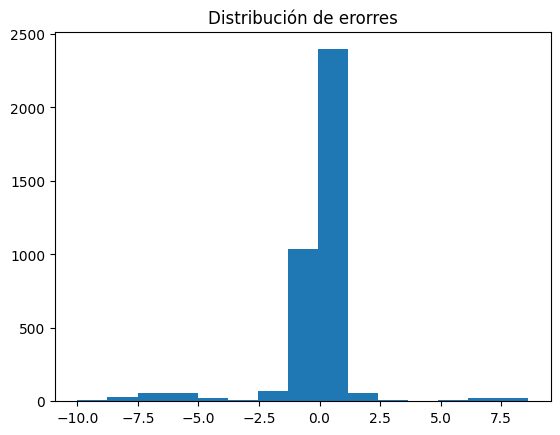

In [63]:
error = y_pred - y_test
plt.hist(error, bins=15)
plt.title("Distribución de erorres");

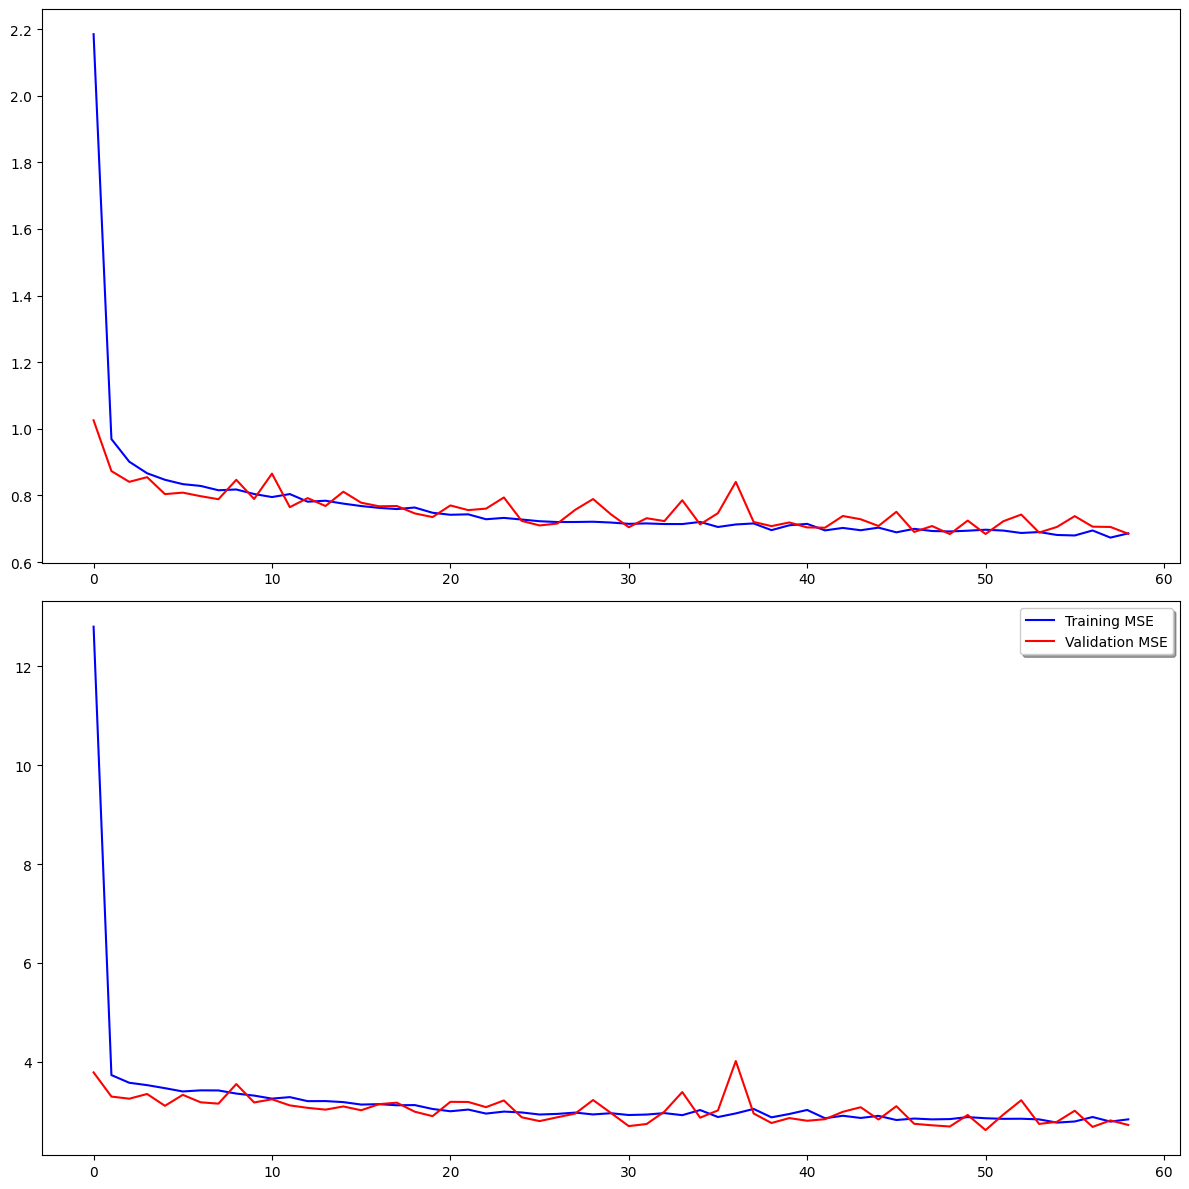

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss - MAE")
ax1.plot(history.history['val_loss'], color='r', label="validation loss - MAE")

ax2.plot(history.history['MSE'], color='b', label="Training MSE")
ax2.plot(history.history['val_MSE'], color='r',label="Validation MSE")

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [65]:
model.save("../models/medium/keras_model.h5")

# Summary

In [66]:
score

{'plr': {'MAE': 1.8729023947316694,
  'MAPE': 3642305621068901.0,
  'MSE': 5.493464488636974,
  'RMSE': 2.3438140900329474,
  'R2_Train': 0.631883002912361,
  'R2_Test': 0.6372847166908994},
 'rfr': {'MAE': 0.8898398043706012,
  'MAPE': 1568007958161719.8,
  'MSE': 2.3319061895209843,
  'RMSE': 1.5270580177324582,
  'R2_Train': 0.9384981051525723,
  'R2_Test': 0.8460319501597049},
 'en': {'MAE': 2.0280036929033907,
  'MAPE': 4307619621270913.0,
  'MSE': 6.267992454767642,
  'RMSE': 2.5035959048471943,
  'R2_Train': 0.5842224169349084,
  'R2_Test': 0.5861451978595669},
 'svr': {'MAE': 1.1460713680665038,
  'MAPE': 2389076939175422.5,
  'MSE': 3.5950331526586923,
  'RMSE': 1.8960572651316976,
  'R2_Train': 0.7635003210842612,
  'R2_Test': 0.7626318562412796},
 'abr': {'MAE': 1.997281085166895,
  'MAPE': 4100736842203801.5,
  'MSE': 6.312366800968291,
  'RMSE': 2.512442397542338,
  'R2_Train': 0.5802620758605064,
  'R2_Test': 0.5832153066065849},
 'gbr': {'MAE': 1.4013988256275487,
  'MAP

In [67]:
parameter

{'plr': {'poli__degree': [2]},
 'rfr': {'regressor__max_depth': [13],
  'regressor__max_features': [6],
  'regressor__min_samples_leaf': [2],
  'regressor__n_estimators': [200]},
 'en': {'regressor__alpha': [0.1],
  'regressor__l1_ratio': [0.9],
  'regressor__max_iter': [1000]},
 'svr': {'regressor__C': [2],
  'regressor__epsilon': [0.01],
  'regressor__kernel': ['rbf']},
 'ada': {'regressor__loss': ['linear'], 'regressor__n_estimators': [100]}}

In [68]:
write_yaml("../models/medium/model_config.yaml", parameter)

YAML file write: OK


True

In [69]:
write_yaml("../models/medium/score.yaml", score)

YAML file write: OK


True

In [70]:
bee()